### References
http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Kaggle gives us mnist train/test data in csv files. First column of train is the label and the other 784 columns are the pixel values of the 28x28x1 images. We use pandas to load the datasets.

In [3]:
# Read in the train and test data.
train_data = pd.read_csv('../mnist_data/train.csv')
test_data = pd.read_csv('../mnist_data/test.csv')
#train_data.head(3)  # Sanity check display the first 3 elements of training.

In [4]:
# Seperate the labels from the input data.
train_y = train_data.values[:,0]
train_x = train_data.values[:,1:].astype(np.float32)
test_x = test_data.values.astype(np.float32)

In [5]:
# Calculate how much of our training data is for train and validation.
VALIDATION_PERCENT = 0.1  # 0.0 to 1.0
num_train = len(train_y)
num_val = int(num_train*VALIDATION_PERCENT)

In [6]:
# Reshape data back to images, transpose to N,C,H,W format for pytorch. 

train_x = train_x.reshape([-1, 28, 28, 1]).transpose((0,3,1,2))
test_x = test_x.reshape([-1, 28, 28, 1]).transpose((0,3,1,2))

# Split for train/val.
val_x = train_x[0:num_val]
val_y = train_y[0:num_val]
train_x = train_x[num_val:]
train_y = train_y[num_val:]

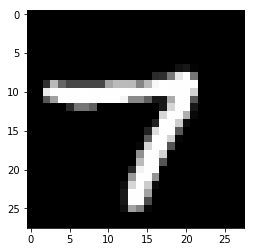

7

In [7]:
# Sanity check to see an example and print its label.
example_im = train_x[0,0,:,:]
plt.imshow(example_im, cmap='gray')
plt.show()
train_y[0]

### Create a pytorch dataset wrapper by creating a class that inherits from Dataset. Will be used to store our datasets so we can use the pytorch DataLoader 

In [8]:
class MnistDataset(Dataset):
    
    def __init__(self, x, y=None):
        self.data = x
        self.labels = y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.data[idx], self.labels[idx]
        else:
            return self.data[idx]

In [9]:
train_dataset = MnistDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True)

val_dataset = MnistDataset(val_x, val_y)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

### Define our CNN model for classifying our digits data. Define it as a class inheriting from nn.Module

In [10]:
class MnistCNN(nn.Module):
    
    def __init__(self):
        super(MnistCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.max2x2 = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels= 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=7*7*32, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.out = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        
        act1 = self.relu(self.conv1(x))
        act2 = self.max2x2(act1)
        act3 = self.relu(self.conv2(act2))
        act4 = self.max2x2(act3)
        flatten = act4.view(-1, 7*7*32)
        act5 = self.relu(self.fc1(flatten))
        act6 = self.relu(self.fc2(act5))
        out = self.out(act6)
        
        return out

In [11]:
def train_model(model, dataloader, loss_func, optimizer, epochs=10):
    
    # Switch to train mode (for things like Batch norm and dropout).
    model.train()
    
    loss_history = []
    
    for epoch in range(epochs):
        for i_batch, (x_batch, y_batch) in enumerate(dataloader):            
            # Compute output and loss.
            output = model(x_batch)
            loss = loss_func(output, y_batch)
        
            # Zero our gradients/backprop and perform and SGD step.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(loss)           
        loss_history.append(loss)
        
    return loss_history

In [12]:
# Define optimizer and loss function.
model = MnistCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# Train our model.
train_model(model, train_dataloader, loss_func, optimizer, epochs=10)

In [15]:
def test_model(model, dataloader):
    model.eval()
    num_correct = 0
    with torch.no_grad():
        for i_batch, (x_batch, y_batch) in enumerate(dataloader):                
            output = model(x_batch)

            _, output = torch.max(output, dim=1)
        
            num_correct += torch.sum(output == y_batch)

    return num_correct

In [16]:
num_correct = test_model(model, val_dataloader)

In [17]:
if VALIDATION_PERCENT > 0:
    accuracy = float(num_correct)/ len(val_dataset)
    print(accuracy)

0.986904761904762


#### Run our test set through to predict labels then save to csv for kaggle

In [18]:
test_x = torch.from_numpy(test_x)
test_labels = []
for i in range(len(test_x)):
    
    test_batch = test_x[i].unsqueeze_(0)
    
    output = model(test_batch)
    _, output = torch.max(output, dim=1)
    
    test_labels.append(int(output.data.numpy()))

np.savetxt("foo.csv", test_labels, delimiter=",")